In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as T
from torchvision.models import resnet50, efficientnet_b0, densenet121, mobilenet_v2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


## 2. Load and Prepare Data


In [2]:
# Load CSV - Try multiple possible paths
csv_paths = [
    '/kaggle/input/kidney-data/kidneyData.csv',
    '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv',
    'kidneyData.csv',
    './nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone/versions/1/kidneyData.csv'
]

df = None
for path in csv_paths:
    if os.path.exists(path):
        df = pd.read_csv(path)
        print(f"Loaded CSV from: {path}")
        break

if df is None:
    raise FileNotFoundError("Could not find kidneyData.csv in any expected location")

print(f"\nTotal samples: {len(df)}")
print(f"\nClass distribution:")
print(df['Class'].value_counts())
print(f"\nTarget distribution:")
print(df['target'].value_counts().sort_index())
df.head()


Loaded CSV from: /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv

Total samples: 12446

Class distribution:
Class
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64

Target distribution:
target
0    3709
1    5077
2    1377
3    2283
Name: count, dtype: int64


,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [3]:
# Function to fix image paths for Kaggle environment
def fix_path(path_str, class_name):
    """Convert path from CSV format to actual dataset path"""
    # Remove quotes if present
    path_str = str(path_str).strip('"')
    
    # Extract filename
    filename = os.path.basename(path_str)
    
    # Try multiple possible base paths
    base_paths = [
        "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
        "/kaggle/input/kidney-data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
        "./nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone/versions/1/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
    ]
    
    for base in base_paths:
        full_path = os.path.join(base, class_name, filename)
        if os.path.exists(full_path):
            return full_path
    
    # Return original if nothing found (will fail later with clear error)
    return path_str

# Apply path fixing
print("Fixing image paths...")
df['corrected_path'] = df.apply(lambda row: fix_path(row['path'], row['Class']), axis=1)

# Verify some paths exist
sample_paths = df['corrected_path'].head(10)
existing = sum([1 for p in sample_paths if os.path.exists(p)])
print(f"Sample check: {existing}/10 paths exist")

# Filter out non-existent paths
initial_count = len(df)
df = df[df['corrected_path'].apply(os.path.exists)]
print(f"\nAfter filtering: {len(df)} samples with valid paths (removed {initial_count - len(df)} invalid paths)")

# Check class distribution after filtering
print(f"\nClass distribution after filtering:")
print(df['Class'].value_counts())


Fixing image paths...
Sample check: 10/10 paths exist

After filtering: 12446 samples with valid paths (removed 0 invalid paths)

Class distribution after filtering:
Class
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64


In [4]:
class KidneyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = row['corrected_path']
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a black image as fallback
            img = Image.new('RGB', (224, 224), color='black')
        
        if self.transform:
            img = self.transform(img)
        
        label = int(row['target'])
        return img, label


## 4. Define Transforms


In [6]:
# ImageNet normalization stats
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training transforms with augmentations
train_tfms = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# Validation/Test transforms (no augmentation)
val_tfms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


## 5. Split Data


In [7]:
# Stratified split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    stratify=df['target'], 
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['target'], 
    random_state=42
)

print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

# Create datasets
train_dataset = KidneyDataset(train_df, transform=train_tfms)
val_dataset = KidneyDataset(val_df, transform=val_tfms)
test_dataset = KidneyDataset(test_df, transform=val_tfms)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Train: 8712 samples
Val: 1867 samples
Test: 1867 samples


## 6. Model Architectures


In [8]:
def get_resnet50(num_classes=4):
    model = resnet50(weights='IMAGENET1K_V2')
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def get_efficientnet_b0(num_classes=4):
    model = efficientnet_b0(weights='IMAGENET1K_V1')
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

def get_densenet121(num_classes=4):
    model = densenet121(weights='IMAGENET1K_V1')
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model

def get_mobilenet_v2(num_classes=4):
    model = mobilenet_v2(weights='IMAGENET1K_V1')
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model


## 7. Training Functions


In [10]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

def train_model(model_name, model, train_loader, val_loader, num_epochs=30, lr=1e-4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    best_model_state = None
    
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Load best model
    model.load_state_dict(best_model_state)
    print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%")
    
    return model, train_losses, train_accs, val_losses, val_accs


In [11]:
def evaluate_model(model, test_loader, device, class_names=['Normal', 'Cyst', 'Stone', 'Tumor']):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    
    test_loss, test_acc, all_preds, all_labels = validate(model, test_loader, criterion, device)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    results = {
        'test_loss': test_loss,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels
    }
    
    return results

def plot_confusion_matrix(cm, class_names, model_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    return ax


In [13]:
# Define models to train
models_config = {
    'ResNet-50': get_resnet50,
    'EfficientNet-B0': get_efficientnet_b0,
    'DenseNet-121': get_densenet121,
    'MobileNetV2': get_mobilenet_v2
}

# Training parameters
num_epochs = 15
learning_rate = 1e-4

# Store results
all_results = {}
all_histories = {}

# Train each model
for model_name, model_fn in models_config.items():
    print(f"\n{'#'*60}")
    print(f"# Training {model_name}")
    print(f"{'#'*60}")
    
    # Create model
    model = model_fn(num_classes=4)
    
    # Train
    trained_model, train_losses, train_accs, val_losses, val_accs = train_model(
        model_name, model, train_loader, val_loader, 
        num_epochs=num_epochs, lr=learning_rate
    )
    
    # Evaluate on test set
    print(f"\nEvaluating {model_name} on test set...")
    test_results = evaluate_model(trained_model, test_loader, device)
    
    # Store results
    all_results[model_name] = test_results
    all_histories[model_name] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }
    
    print(f"\n{model_name} Test Results:")
    print(f"  Accuracy: {test_results['test_acc']:.2f}%")
    print(f"  Precision (Macro): {test_results['precision_macro']:.4f}")
    print(f"  Recall (Macro): {test_results['recall_macro']:.4f}")
    print(f"  F1-Score (Macro): {test_results['f1_macro']:.4f}")



############################################################
# Training ResNet-50
############################################################

Training ResNet-50
Epoch [5/15]
  Train Loss: 0.0109, Train Acc: 99.71%
  Val Loss: 0.0184, Val Acc: 99.46%
Epoch [10/15]
  Train Loss: 0.0070, Train Acc: 99.83%
  Val Loss: 0.0111, Val Acc: 99.52%
Epoch [15/15]
  Train Loss: 0.0071, Train Acc: 99.79%
  Val Loss: 0.0038, Val Acc: 99.79%

Best Validation Accuracy: 99.79%

Evaluating ResNet-50 on test set...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



ResNet-50 Test Results:
  Accuracy: 99.95%
  Precision (Macro): 0.9988
  Recall (Macro): 0.9996
  F1-Score (Macro): 0.9992

############################################################
# Training EfficientNet-B0
############################################################


100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s] 



Training EfficientNet-B0
Epoch [5/15]
  Train Loss: 0.0137, Train Acc: 99.64%
  Val Loss: 0.0027, Val Acc: 99.95%
Epoch [10/15]
  Train Loss: 0.0118, Train Acc: 99.71%
  Val Loss: 0.0048, Val Acc: 99.95%
Epoch [15/15]
  Train Loss: 0.0021, Train Acc: 99.94%
  Val Loss: 0.0008, Val Acc: 100.00%

Best Validation Accuracy: 100.00%

Evaluating EfficientNet-B0 on test set...

EfficientNet-B0 Test Results:
  Accuracy: 99.95%
  Precision (Macro): 0.9996
  Recall (Macro): 0.9988
  F1-Score (Macro): 0.9992

############################################################
# Training DenseNet-121
############################################################


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 151MB/s] 


Training DenseNet-121


Epoch [5/15]
  Train Loss: 0.0199, Train Acc: 99.43%
  Val Loss: 0.0091, Val Acc: 99.73%
Epoch [10/15]
  Train Loss: 0.0076, Train Acc: 99.76%
  Val Loss: 0.0495, Val Acc: 98.55%
Epoch [15/15]
  Train Loss: 0.0004, Train Acc: 100.00%
  Val Loss: 0.0005, Val Acc: 100.00%

Best Validation Accuracy: 100.00%

Evaluating DenseNet-121 on test set...


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



DenseNet-121 Test Results:
  Accuracy: 99.89%
  Precision (Macro): 0.9991
  Recall (Macro): 0.9976
  F1-Score (Macro): 0.9983

############################################################
# Training MobileNetV2
############################################################


100%|██████████| 13.6M/13.6M [00:00<00:00, 98.1MB/s]


Training MobileNetV2


Epoch [5/15]
  Train Loss: 0.0220, Train Acc: 99.30%
  Val Loss: 0.0101, Val Acc: 99.63%
Epoch [10/15]
  Train Loss: 0.0097, Train Acc: 99.72%
  Val Loss: 0.0012, Val Acc: 100.00%
Epoch [15/15]
  Train Loss: 0.0021, Train Acc: 99.91%
  Val Loss: 0.0014, Val Acc: 99.95%

Best Validation Accuracy: 100.00%

Evaluating MobileNetV2 on test set...

MobileNetV2 Test Results:
  Accuracy: 99.95%
  Precision (Macro): 0.9988
  Recall (Macro): 0.9996
  F1-Score (Macro): 0.9992


## 10. Model Comparison - Metrics Table


In [19]:
# Create comparison dataframe
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Test Accuracy (%)': f"{results['test_acc']:.2f}",
        'Precision (Macro)': f"{results['precision_macro']:.4f}",
        'Recall (Macro)': f"{results['recall_macro']:.4f}",
        'F1-Score (Macro)': f"{results['f1_macro']:.4f}",
        'Test Loss': f"{results['test_loss']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("MODEL COMPARISON - OVERALL METRICS")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)



MODEL COMPARISON - OVERALL METRICS
          Model Test Accuracy (%) Precision (Macro) Recall (Macro) F1-Score (Macro) Test Loss
      ResNet-50             99.95            0.9988         0.9996           0.9992    0.0018
EfficientNet-B0             99.95            0.9996         0.9988           0.9992    0.0020
   DenseNet-121             99.89            0.9991         0.9976           0.9983    0.0038
    MobileNetV2             99.95            0.9988         0.9996           0.9992    0.0010



## 11. Detailed Per-Class Metrics


In [31]:
class_names = ['Normal', 'Cyst', 'Stone', 'Tumor']

print("\n" + "="*80)
print("DETAILED PER-CLASS METRICS")
print("="*80)

for model_name, results in all_results.items():
    print(f"\n{model_name}:")
    print("-" * 60)
    print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 60)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<10} {results['precision'][i]:<12.4f} {results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f}")
    print(f"{'Macro Avg':<10} {results['precision_macro']:<12.4f} {results['recall_macro']:<12.4f} {results['f1_macro']:<12.4f}")



DETAILED PER-CLASS METRICS

ResNet-50:
------------------------------------------------------------
Class      Precision    Recall       F1-Score    
------------------------------------------------------------
Normal     1.0000       0.9982       0.9991      
Cyst       1.0000       1.0000       1.0000      
Stone      0.9952       1.0000       0.9976      
Tumor      1.0000       1.0000       1.0000      
Macro Avg  0.9988       0.9996       0.9992      

EfficientNet-B0:
------------------------------------------------------------
Class      Precision    Recall       F1-Score    
------------------------------------------------------------
Normal     0.9982       1.0000       0.9991      
Cyst       1.0000       1.0000       1.0000      
Stone      1.0000       0.9952       0.9976      
Tumor      1.0000       1.0000       1.0000      
Macro Avg  0.9996       0.9988       0.9992      

DenseNet-121:
------------------------------------------------------------
Class      Precision  

## 12. Visualization - Training Curves


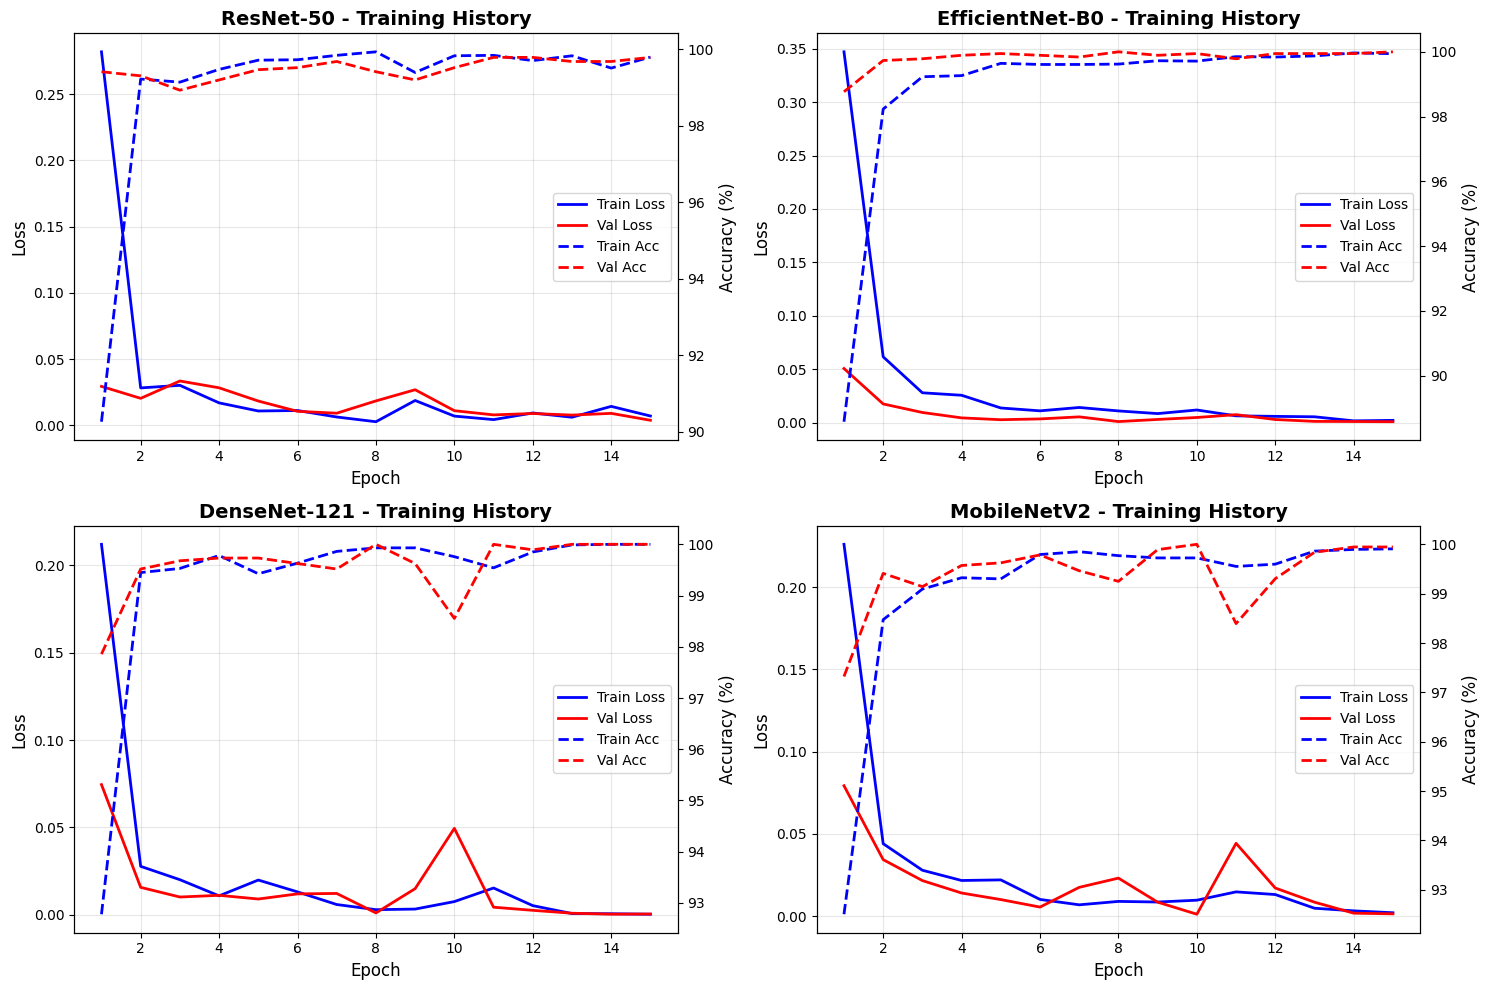

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Plot for each model
for idx, (model_name, history) in enumerate(all_histories.items()):
    ax = axes[idx]
    epochs = range(1, len(history['train_losses']) + 1)
    
    ax2 = ax.twinx()
    
    # Loss curves
    line1 = ax.plot(epochs, history['train_losses'], 'b-', label='Train Loss', linewidth=2)
    line2 = ax.plot(epochs, history['val_losses'], 'r-', label='Val Loss', linewidth=2)
    
    # Accuracy curves
    line3 = ax2.plot(epochs, history['train_accs'], 'b--', label='Train Acc', linewidth=2)
    line4 = ax2.plot(epochs, history['val_accs'], 'r--', label='Val Acc', linewidth=2)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12, color='black')
    ax2.set_ylabel('Accuracy (%)', fontsize=12, color='black')
    ax.set_title(f'{model_name} - Training History', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Combine legends
    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='center right')

plt.tight_layout()
plt.show()


## 13. Visualization - Confusion Matrices


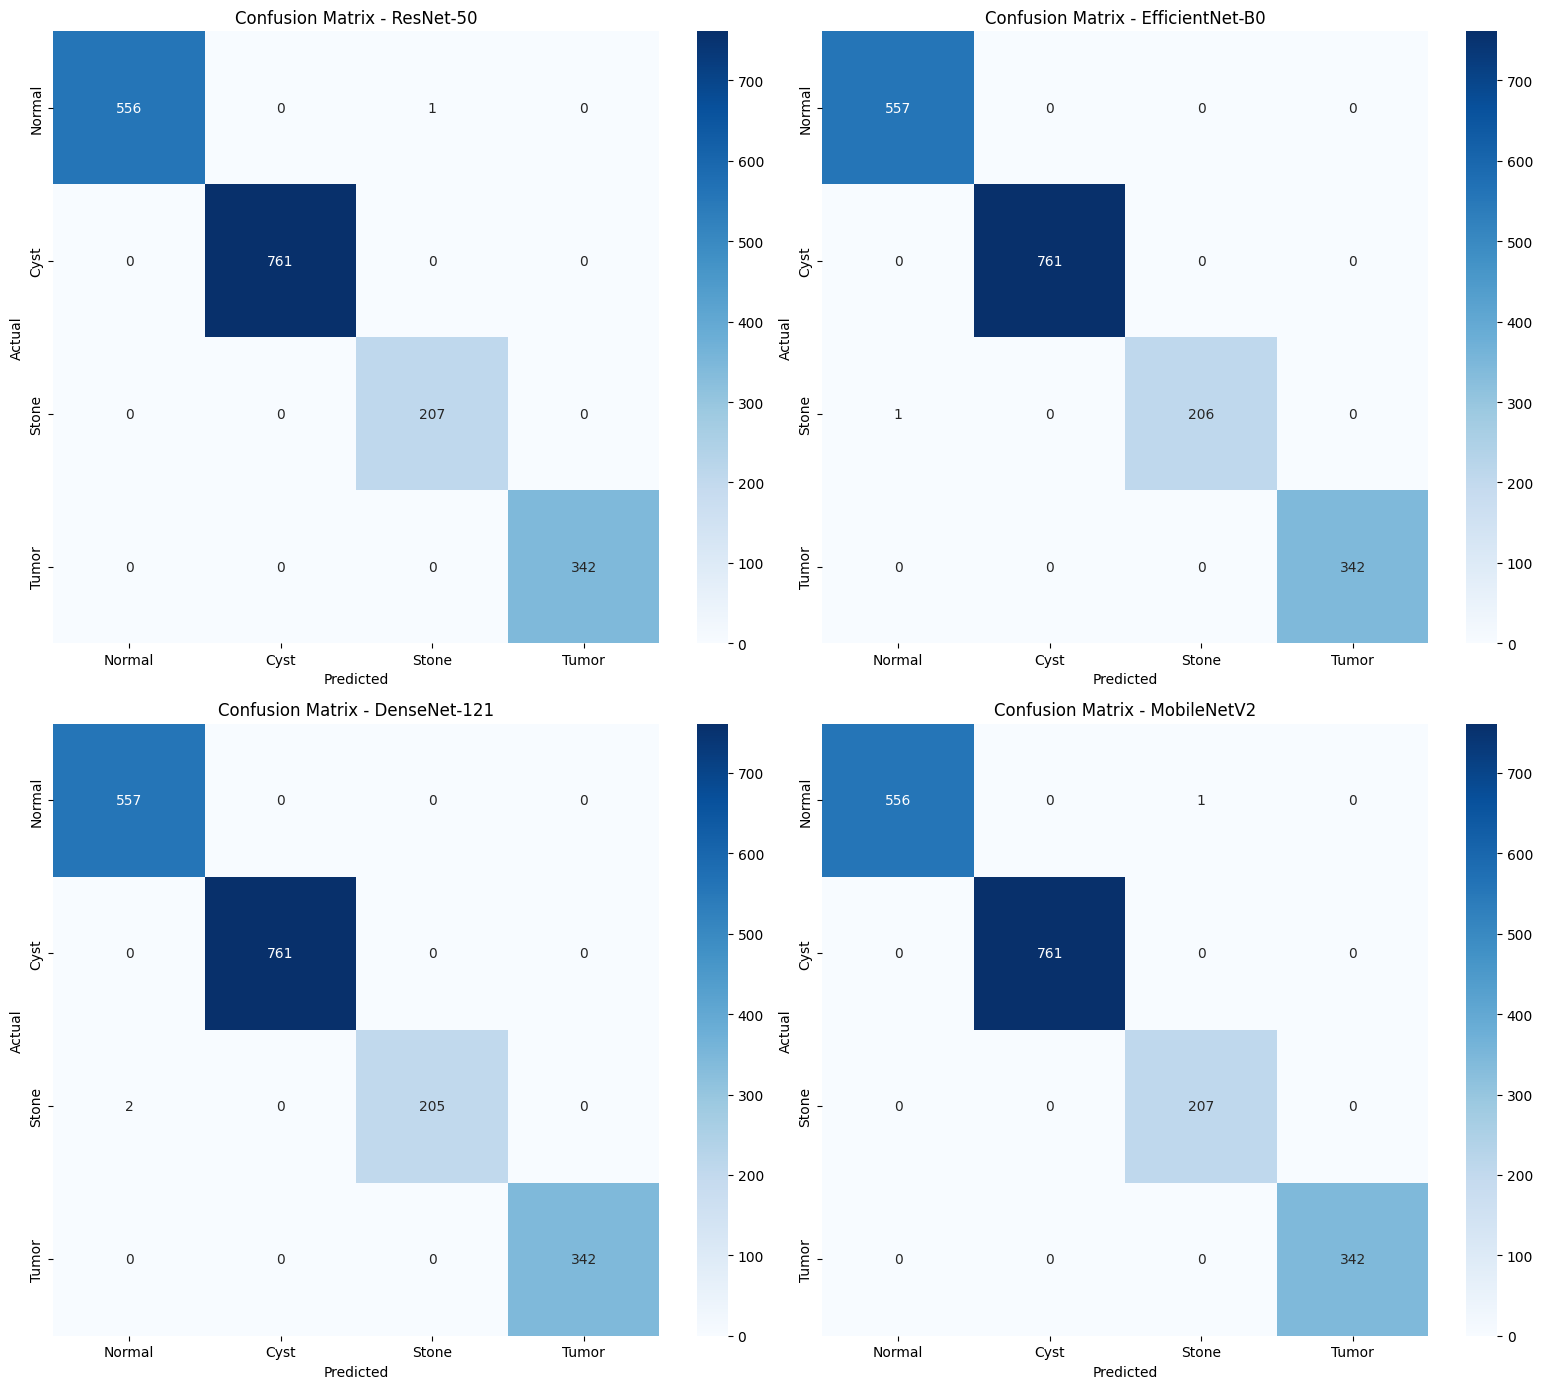

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (model_name, results) in enumerate(all_results.items()):
    plot_confusion_matrix(results['confusion_matrix'], class_names, model_name, ax=axes[idx])

plt.tight_layout()
plt.show()


## 14. Visualization - Model Comparison Bar Chart


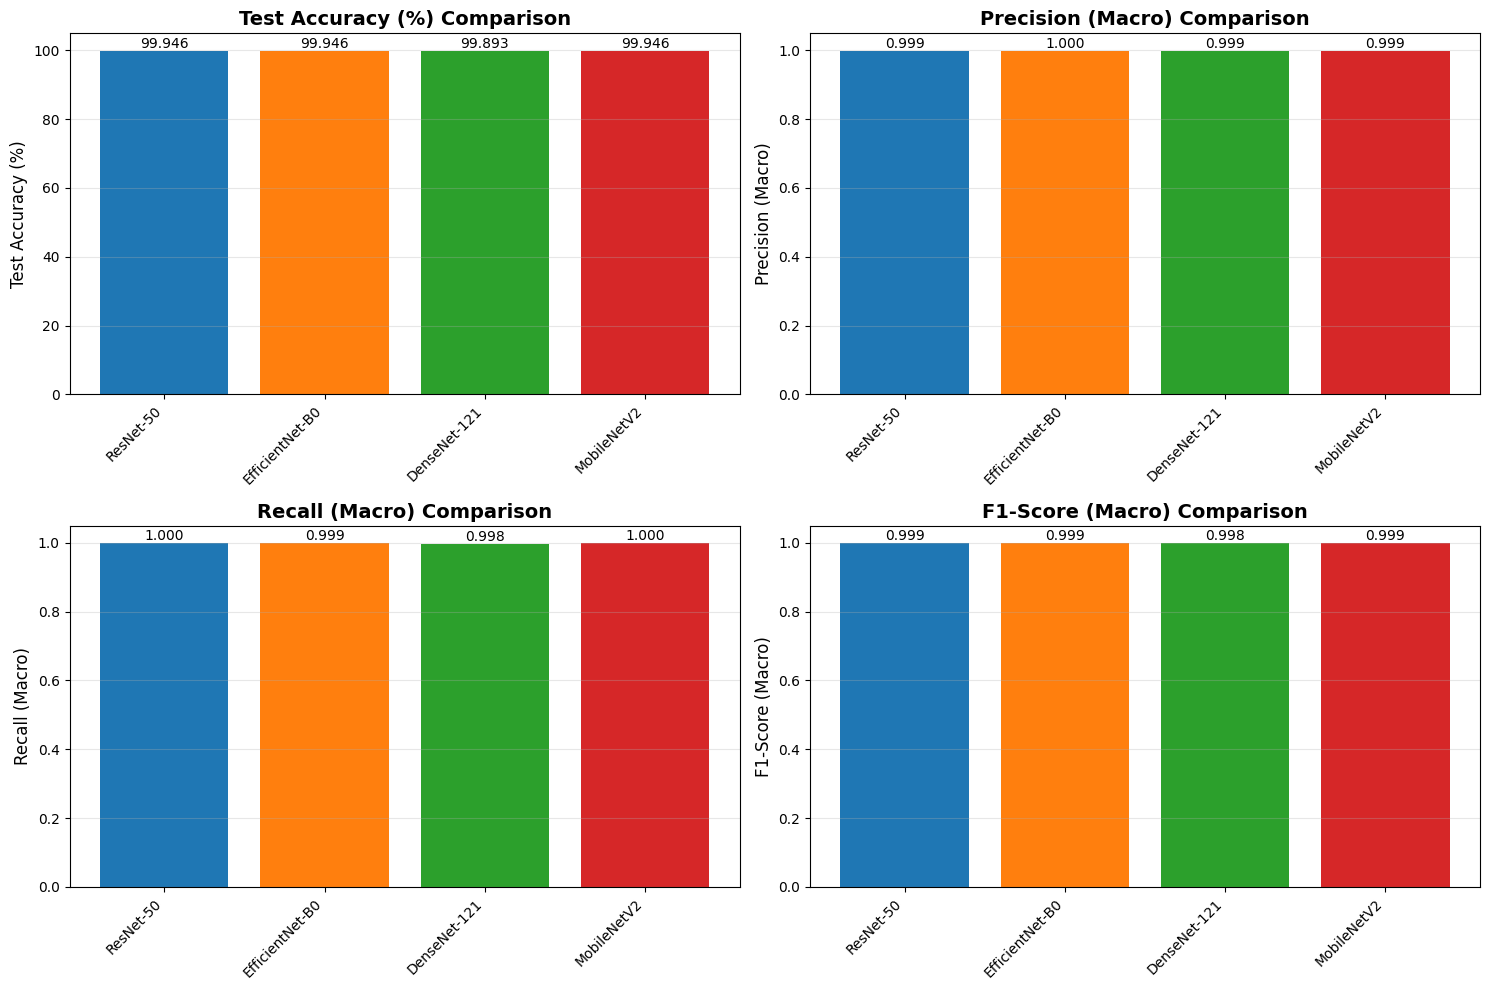

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

metrics = ['test_acc', 'precision_macro', 'recall_macro', 'f1_macro']
metric_labels = ['Test Accuracy (%)', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']

for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axes[idx]
    model_names = list(all_results.keys())
    values = [all_results[name][metric] for name in model_names][[]]
    
    bars = ax.bar(model_names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax.set_ylabel(label, fontsize=12)
    ax.set_title(f'{label} Comparison', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


## 15. Final Summary and Recommendations


In [38]:
print("\n" + "="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

# Find best model for each metric
best_acc_model = max(all_results.items(), key=lambda x: x[1]['test_acc'])
best_f1_model = max(all_results.items(), key=lambda x: x[1]['f1_macro'])
best_precision_model = max(all_results.items(), key=lambda x: x[1]['precision_macro'])
best_recall_model = max(all_results.items(), key=lambda x: x[1]['recall_macro'])

print(f"\n🏆 Best Accuracy: {best_acc_model[0]} ({best_acc_model[1]['test_acc']:.2f}%)")
print(f"🏆 Best F1-Score: {best_f1_model[0]} ({best_f1_model[1]['f1_macro']:.4f})")
print(f"🏆 Best Precision: {best_precision_model[0]} ({best_precision_model[1]['precision_macro']:.4f})")
print(f"🏆 Best Recall: {best_recall_model[0]} ({best_recall_model[1]['recall_macro']:.4f})")

print("\n" + "-"*80)
print("RECOMMENDATIONS:")
print("-"*80)
print("\n1. For Production Deployment:")
print(f"   → Use {best_acc_model[0]} for best overall performance")
print("\n2. For Medical Applications (High Precision Required):")
print(f"   → Use {best_precision_model[0]} to minimize false positives")
print("\n3. For Screening (High Recall Required):")
print(f"   → Use {best_recall_model[0]} to minimize false negatives")
print("\n4. For Balanced Performance:")
print(f"   → Use {best_f1_model[0]} for best precision-recall balance")

print("\n" + "="*80)



FINAL SUMMARY AND RECOMMENDATIONS

🏆 Best Accuracy: ResNet-50 (99.95%)
🏆 Best F1-Score: ResNet-50 (0.9992)
🏆 Best Precision: EfficientNet-B0 (0.9996)
🏆 Best Recall: ResNet-50 (0.9996)

--------------------------------------------------------------------------------
RECOMMENDATIONS:
--------------------------------------------------------------------------------

1. For Production Deployment:
   → Use ResNet-50 for best overall performance

2. For Medical Applications (High Precision Required):
   → Use EfficientNet-B0 to minimize false positives

3. For Screening (High Recall Required):
   → Use ResNet-50 to minimize false negatives

4. For Balanced Performance:
   → Use ResNet-50 for best precision-recall balance

